# Joint Fitting example

This notebook covers how to perform joint inference and optimization for multiple observations, using ndspec's fit objects. This notebook has combines two analyses from previous tutorials and explores how constraints on parameters change when performing joint fitting and inference. See the following for more detailed explanations of fitting: [power spectra](https://ndspec.readthedocs.io/en/latest/fit_psd.html), [time-averaged spectra](https://ndspec.readthedocs.io/en/latest/fit_spec.html), [1-D cross-spectra](https://ndspec.readthedocs.io/en/latest/fit_cross_1d.html) and [2-D cross-spectra](https://ndspec.readthedocs.io/en/latest/fit_cross_2d.html).

First, we'll import important packages (as well as set some specific environment variables that helps with performance when using numpy in parallel frameworks such as in emcee which is further explained in [performance considerations](https://ndspec.readthedocs.io/en/latest/)).

In [1]:
import os

os.environ["OMP_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" 
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" 
os.environ["NUMEXPR_NUM_THREADS"] = "1" 

import sys
import numpy as np

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.pyplot as plt

import multiprocessing as mp
mp.set_start_method("fork")

from ndspec.Response import ResponseMatrix
import ndspec.FitCrossSpectrum as fitcross
import ndspec.FitTimeAvgSpectrum as fitspec
import ndspec.models as models
from ndspec.SimpleFit import load_lc

## Loading Data
We'll be using the same data and performing the same data preparation as the earlier tutorials: [Fitting a time averaged spectrum](https://ndspec.readthedocs.io/en/latest/fit_spec.html) and [Fitting a one-dimensional cross-spectrum](https://ndspec.readthedocs.io/en/latest/fit_cross_1d.html). We'll load all of our data, and rebin the energy matrices into more appropriate bins for the cross-spectrum and time-averaged energy spectrum. See the previous tutorials for the full explanation of why and how we rebin the response matrices.

In [ ]:
#load and rebin response - we need this to have the exact intervals for our energy bins
path = os.getcwd()

rmfpath = path+"/responses/1200120106_rmf.pha"
nicer_matrix = ResponseMatrix(rmfpath)
arfpath = path+"/responses/1200120106_arf.pha"
nicer_matrix.load_arf(arfpath)

#deal with cross-spectrum
nicer_energy_rebin = nicer_matrix.rebin_energies(10)

rebin_bounds = np.geomspace(0.5,10,41)
rebin_bounds = np.append(np.min(nicer_matrix.emin),rebin_bounds)
rebin_bounds = np.append(rebin_bounds,np.max(nicer_matrix.emax))

rebin_bounds_lo = rebin_bounds[:-1]
rebin_bounds_hi = rebin_bounds[1:]
rebin_response = nicer_matrix.rebin_channels(rebin_bounds_lo,rebin_bounds_hi)

channel_grid = 0.5*(rebin_response.emax+rebin_response.emin)
channel_width = rebin_response.emax-rebin_response.emin
#finally, find the array of energy channel edges that line up with the response and are roughly geometrically spaced
fine_channel_grid_edges = np.append(channel_grid-0.5*channel_width,channel_grid[-1]+0.5*channel_width[-1])

#deal with energy spectrum
rebin_matrix = nicer_matrix.rebin_energies(4)
spectrum_fit = fitspec.FitTimeAvgSpectrum()

spectrum_fit.set_data(rebin_matrix,os.getcwd()+'/spectra/1200120106_rebin.pha')

Arf missing, please load it
No exposure header found in ARF, setting exposure time to 1 second
Arf loaded


/Users/benr/projects/nDspec/ndspec/Response.py:390: UserWarning: WARNING: rebinning a response in energy is dangerous, use at your own risk!
  warnings.warn("WARNING: rebinning a response in energy is dangerous, use at your own risk!",


In [ ]:
#convert from lightcurves to lag-energy spectra with Stingray
from ndspec.SimpleFit import load_lc
from stingray.fourier import avg_cs_from_timeseries, avg_pds_from_timeseries
from stingray.fourier import poisson_level
from stingray.fourier import error_on_averaged_cross_spectrum
from stingray.utils import show_progress

def lag_from_lcs(lc_strings,lc_ref,freq_lo,freq_hi,seg_size,time_res):
    time_ref,counts_ref,gtis_ref = load_lc(lc_ref)
    results = avg_pds_from_timeseries(
            time_ref,
            gtis_ref,
            seg_size,
            time_res,
            silent=True,
            norm="none",
            fluxes=counts_ref,)
    freq = results["freq"]
    ref_power = results["power"]
    m_ave = results.meta["m"]
    ref_power_noise = poisson_level(norm="none", n_ph=np.sum(counts_ref) / m_ave)
    freq_mask = (freq>freq_lo) & (freq<freq_hi)
    n_freqs = freq_mask[freq_mask==True].size
    mean_ref_power = np.mean(ref_power[freq_mask])
    m_tot = n_freqs * m_ave
    f_mean = (freq_lo + freq_hi)*0.5

    lag_spec = []
    lag_spec_err = []

    for i in range(len(lc_strings)):
        time_sub,counts_sub,gtis_sub = load_lc(lc_strings[i])

        results_cross = avg_cs_from_timeseries(
                time_sub,
                time_ref,
                gtis_sub,
                seg_size,
                time_res,
                silent=True,
                norm="none",
                fluxes1=counts_sub,
                fluxes2=counts_ref,
            )

        results_ps = avg_pds_from_timeseries(
                time_sub,
                gtis_sub,
                seg_size,
                time_res,
                silent=True,
                norm="none",
                fluxes=counts_sub,
            )

        sub_power_noise = poisson_level(
            norm="none", n_ph=np.sum(counts_sub) / results_ps.meta["m"]
        )
        cross = results_cross["power"]
        sub_power = results_ps["power"]
        Cmean = np.mean(cross[freq_mask])
        mean_sub_power = np.mean(sub_power[freq_mask])

        _, _, phi_e, _ = error_on_averaged_cross_spectrum(
                Cmean,
                mean_sub_power,
                mean_ref_power,
                m_tot,
                sub_power_noise,
                ref_power_noise,
                common_ref=True,
            )

        phase = np.angle(Cmean)
        lag_spec = np.append(lag_spec,phase/(2*np.pi*f_mean))
        lag_spec_err = np.append(lag_spec_err,phi_e/(2*np.pi*f_mean))



    return lag_spec, lag_spec_err

In [7]:
#round the bins of the channels in each lightcurve
fine_channel_string = []
for i in range(len(fine_channel_grid_edges)):
    bin = "%.0f" % round(100.*fine_channel_grid_edges[i],2)
    fine_channel_string = np.append(fine_channel_string,bin)
fine_channel_string = np.array(fine_channel_string,dtype=int)

#create the path to each lightcurve
fine_full_string = []
for i in range(len(fine_channel_string)-1):
    bin_string = "_"+str(fine_channel_string[i])+"-"+str(fine_channel_string[i+1]-1)
    lc_string = path+"/lightcurves/ni1200120106mpu7_sr" + bin_string + ".lc"
    fine_full_string = np.append(fine_full_string,lc_string)

ref_path = path+"/lightcurves/ni1200120106mpu7_sr_reference.lc"

#define the frequency bounds and, time resolution, reference band  and segment size, and load the data
freqs = np.geomspace(0.2,16,7)

lags = []
lags_err = []

dt = 0.03
segment_size = 5
ref_band = [0.5, 10]

for i in show_progress(range(6)):
    lag,lag_err=lag_from_lcs(fine_full_string,ref_path,freqs[i],freqs[i+1],segment_size,dt)
    lags = np.append(lags,lag)
    lags_err = np.append(lags_err,lag_err)

100%|██████████| 6/6 [00:25<00:00,  4.22s/it]


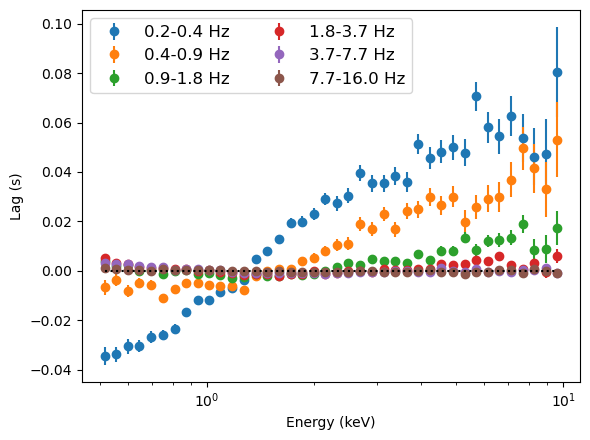

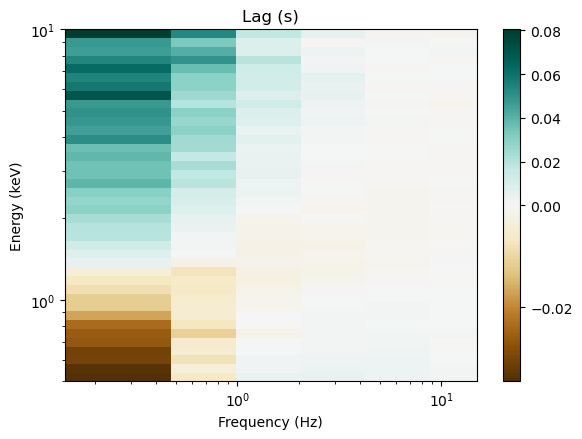

In [ ]:
lags_fit = fitcross.FitCrossSpectrum()
lags_fit.set_coordinates("lags")
lags_fit.set_product_dependence("energy")

#nicer_matrix
#nicer_energy_rebin
lags_fit.set_data(nicer_energy_rebin,ref_band,fine_channel_grid_edges,
                  lags,lags_err,
                  freq_bins=freqs,
                  time_res=dt,seg_size=segment_size)
lags_fit.ignore_energies(0,0.5)
lags_fit.ignore_energies(10.0,fine_channel_grid_edges[-1])

## Define models
So far, we've loaded in the data and created two Fit objects, Next, let's define our time-averaged spectrum model (with some help from pyxspec - eww gross).

In [4]:
from scipy.interpolate import interp1d
from xspec import *
Xset.chatter = 0

def powerlaw(energ,index,norm_pl):
    par_array = np.array([norm_pl,index])
    model = models.powerlaw(energ,par_array)
    if np.any(np.isnan(model)):
        print("Bad PL")
    return model

def wrap_diskbb(energ,kT,norm_disk):
    model = Model("diskbb")
    model.diskbb.Tin = kT
    model.diskbb.norm = norm_disk
    Plot("model")
    diskbb_x = np.array(Plot.x())
    diskbb_y = np.array(Plot.model())
    interp_obj = interp1d(diskbb_x,diskbb_y,fill_value='extrapolate')
    model = interp_obj(energ)*energ
    
    if np.any(np.isnan(model)):
        print("Bad disk")
    return model

#the xspec wrappers completely fuck up with emcee
def blackbody(energ,kT,norm_disk):
    par_array = np.array([norm_disk,kT])
    model = models.bbody(energ,par_array)
    
    if np.any(np.isnan(model)):
        print("Bad BB")
    return model

def wrap_tbabs(energ,nH):
    model = Model("tbabs*po")
    model.TBabs.nH = nH
    model.powerlaw.PhoIndex = 0.0
    model.powerlaw.norm = 1.0
    Plot("model")
    tbabs_x = np.array(Plot.x())
    tbabs_y = np.array(Plot.model())
    interp_obj = interp1d(tbabs_x,tbabs_y,fill_value='extrapolate')
    model = interp_obj(energ)
    
    if np.any(np.isnan(model)):
        print("Bad tbabs")
    return model

## Perform fit

Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
index         -1.65       -3       -1     None     True     None     None
kT             0.25      0.1        1     None     True     None     None
nH              0.1    0.001       10     None     True     None     None
norm_disk     2e+05       10    1e+08     None     True     None     None
norm_pl         6.5      0.1       50     None     True     None     None
tbvabs Version 2.3
Cosmic absorption with grains and H2, modified from
Wilms, Allen, & McCray, 2000, ApJ 542, 914-924
Questions: Joern Wilms
joern.wilms@sternwarte.uni-erlangen.de
joern.wilms@fau.de

http://pulsar.sternwarte.uni-erlangen.de/wilms/research/tbabs/

PLEASE NOTICE:
To get the model described by the above paper
you will also have to set the abundances:
   abund wilm

Note that this routine ignores the current cross section setting
as it always HAS to use the Verner cross sections as a baseline.
Goodness of fit metrics:
Chi squared      

/Users/benr/projects/nDspec/ndspec/Response.py:651: RuntimeWarning: invalid value encountered in divide
  unfold_model = array/unfold_array*channel_widths
/Users/benr/projects/nDspec/ndspec/Response.py:651: RuntimeWarning: divide by zero encountered in divide
  unfold_model = array/unfold_array*channel_widths


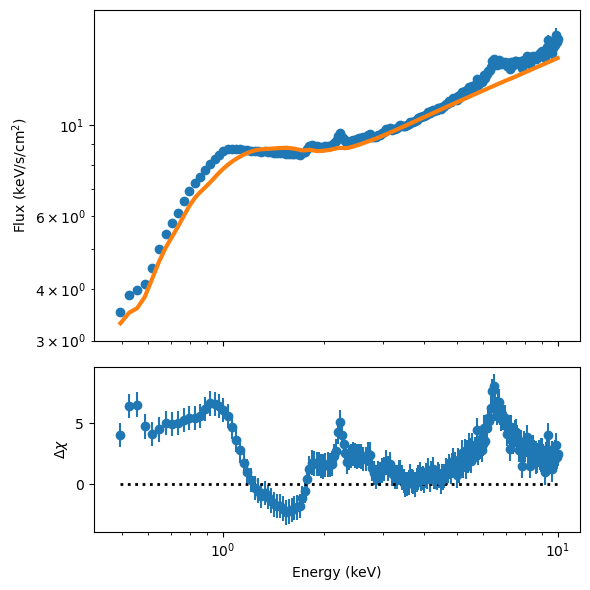

In [5]:
from lmfit import Model as LM_Model
mpl.rcParams.update(mpl.rcParamsDefault)
unfolded_model = LM_Model(wrap_tbabs)*(LM_Model(powerlaw)+LM_Model(wrap_diskbb))

start_params = unfolded_model.make_params(index=dict(value=-1.65,min=-3.0,max=-1.0),
                                          norm_pl=dict(value=6.5,min=1e-1,max=50.),
                                          kT=dict(value=0.25,min=0.10,max=1),
                                          norm_disk=dict(value=2e5,min=1e1,max=1e8),
                                          nH=dict(value=0.1,min=1e-3,max=10))

spectrum_fit.set_model(unfolded_model,params=start_params)
spectrum_fit.model_params.pretty_print()
spectrum_fit.print_fit_stat()
spectrum_fit.plot_model(units='eeunfold')
plt.show()

Not too bad. Let's do the same for the cross-spectrum.

In [9]:
#get the absorption for the value found in the spectral fit. Since we're fixing it we don't need to run the model multiple times
from scipy.interpolate import interp1d
from ndspec.Timing import PowerSpectrum, CrossSpectrum
from xspec import *
Xset.chatter = 0

#wrap PyXspec for tbabs
def wrap_tbabs_tl(energs,nH):
    model = Model("tbabs*po")
    model.TBabs.nH = nH
    model.powerlaw.PhoIndex = 0.0
    model.powerlaw.norm = 1.0
    Plot("model")
    tbabs_x = np.array(Plot.x())
    tbabs_y = np.array(Plot.model())
    interp_obj = interp1d(tbabs_x,tbabs_y,fill_value='extrapolate')
    model = interp_obj(energs)
    return model

#this is defined in the Fourier domain as a transfer function
def pivoting_lowecut(energs,freqs,norm_pl2,index,gamma_0,gamma_slope,phi_0,phi_slope,nu_0,cutoff):
    param_array = np.array([norm_pl2,index,gamma_0,gamma_slope,phi_0,phi_slope,nu_0])
    model = np.transpose(models.pivoting_pl(freqs,energs,param_array))*np.exp(-cutoff/energs)
    return model

#the reverberation models are defined in the time domain, so we need to define a cross spectrum to
#convert it to a transfer function to then return
def reverb(energs,times,rev_norm,rev_temp,rise_slope,decay_slope,peak_time,temp_slope):
    param_array = np.array([rev_norm,rev_temp,rise_slope,decay_slope,peak_time,temp_slope])
    impulse_response = models.bbody_bkn(times,energs,param_array)
    cross_spec = CrossSpectrum(times,energ=energs)
    cross_spec.set_impulse(impulse_response)
    cross_spec.transfer_from_irf()
    model = np.transpose(cross_spec.trans_func)
    return model

psd = PowerSpectrum(lags_fit._times)
#set Lorentzian parameters from the PSD fit
l1_pars = np.array([0.056,0.31,0.251])
l2_pars = np.array([0.85,0.09,0.164])
l3_pars = np.array([2.52,0.35,0.117])
psd_model = models.lorentz(psd.freqs,l1_pars)+models.lorentz(psd.freqs,l2_pars)+models.lorentz(psd.freqs,l3_pars)
psd.power_spec = psd_model

In [10]:
from lmfit import Model as LM_Model

timing_model = LM_Model(wrap_tbabs_tl)*(LM_Model(pivoting_lowecut,independent_vars=['energs','freqs'])+
                                    LM_Model(reverb,independent_vars=['energs','times']))

start_params = timing_model.make_params(norm_pl2=dict(value=1,min=1e-3,max=1e4,vary=False),
                                        index=dict(value=-1.598,min=-1.8,max=-1.4,vary=False),
                                        gamma_0=dict(value=0.046,min=0,max=0.5,vary=True),
                                        gamma_slope=dict(value=-0.016,min=-0.1,max=0,vary=True),
                                        phi_0=dict(value=-2.31,min=-np.pi,max=np.pi,vary=True),
                                        phi_slope=dict(value=2.01,min=-3.,max=3.0,vary=True),
                                        nu_0=dict(value=lags_fit.freq_bounds[0],min=0.0001,max=10,vary=False),
                                        cutoff=dict(value=0.20,min=0.01,max=0.8,vary=False,expr='rev_temp'),
                                        rev_norm=dict(value=0.85,min=0,max=1e4,vary=True),
                                        rev_temp=dict(value=0.20,min=0.01,max=0.8,vary=False),
                                        rise_slope=dict(value=4,min=0,max=10,vary=False),
                                        decay_slope=dict(value=-1.46,min=-10,max=0,vary=True),
                                        peak_time=dict(value=0.01,min=0.0,max=0.2,vary=False),
                                        temp_slope=dict(value=-0.04,min=-3,max=0,vary=True),
                                        nH=dict(value=0.093,min=1e-3,max=10)
                                        )


lags_fit.set_model(timing_model,model_type="transfer")
lags_fit.set_psd_weights(psd)
lags_fit.set_params(start_params)
test = lags_fit.eval_model()

no_renorm_params = lags_fit.model_params
lags_fit.renorm_phases(True)

 - Adding parameter "nH"
 - Adding parameter "norm_pl2"
 - Adding parameter "index"
 - Adding parameter "gamma_0"
 - Adding parameter "gamma_slope"
 - Adding parameter "phi_0"
 - Adding parameter "phi_slope"
 - Adding parameter "nu_0"
 - Adding parameter "cutoff"
 - Adding parameter "rev_norm"
 - Adding parameter "rev_temp"
 - Adding parameter "rise_slope"
 - Adding parameter "decay_slope"
 - Adding parameter "peak_time"
 - Adding parameter "temp_slope"


# Combining the two

Okay, now that we have two models, we want to try and share parameters between them. To do that, we're going to use ndspec's JointFit class.

In [11]:
from ndspec.JointFit import JointFit

In [12]:
bigFit = JointFit()

In [13]:
bigFit.add_fitobj(spectrum_fit,"time_avg_spectrum")
bigFit.add_fitobj(lags_fit,"time_lags")
bigFit.share_params(spectrum_fit,lags_fit,["index","nH"])


                              Caution: nH is already a model parameter.
                              Do you intend for these parameters to be linked?
                              If not, give it a different name to differentiate
                              between multiple instances of the same type for
                              different models.
                              

                              Caution: index is already a model parameter.
                              Do you intend for these parameters to be linked?
                              If not, give it a different name to differentiate
                              between multiple instances of the same type for
                              different models.
                              


In [14]:
bigFit.fit_data()   

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1562
    # data points      = 475
    # variables        = 18
    chi-square         = 1987.51383
    reduced chi-square = 4.34904557
    Akaike info crit   = 715.879374
    Bayesian info crit = 790.819041
[[Variables]]
    nH:              0.09285120 +/- 0.00592924 (6.39%) (init = 0.1)
    index:          -1.59793873 +/- 0.00881552 (0.55%) (init = -1.65)
    norm_pl:         6.25537356 +/- 0.09236123 (1.48%) (init = 6.5)
    kT:              0.23913579 +/- 0.00578421 (2.42%) (init = 0.25)
    norm_disk:       294564.023 +/- 48570.5819 (16.49%) (init = 200000)
    norm_pl2:        1 (fixed)
    gamma_0:         0.09535885 +/- 0.00801264 (8.40%) (init = 0.046)
    gamma_slope:    -0.03604491 +/- 0.00797790 (22.13%) (init = -0.016)
    phi_0:          -2.02932132 +/- 0.14615364 (7.20%) (init = -2.31)
    phi_slope:       1.89379142 +/- 0.18014985 (9.51%) (init = 2.01)
    nu_0:            0.2 (fixed)
    cutoff:

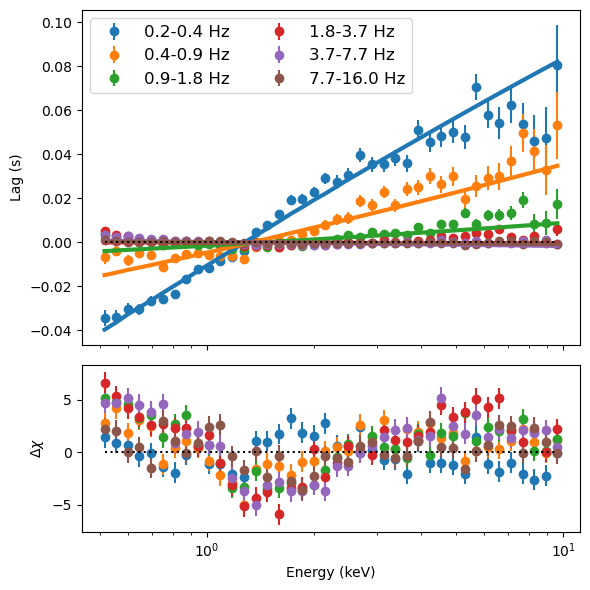

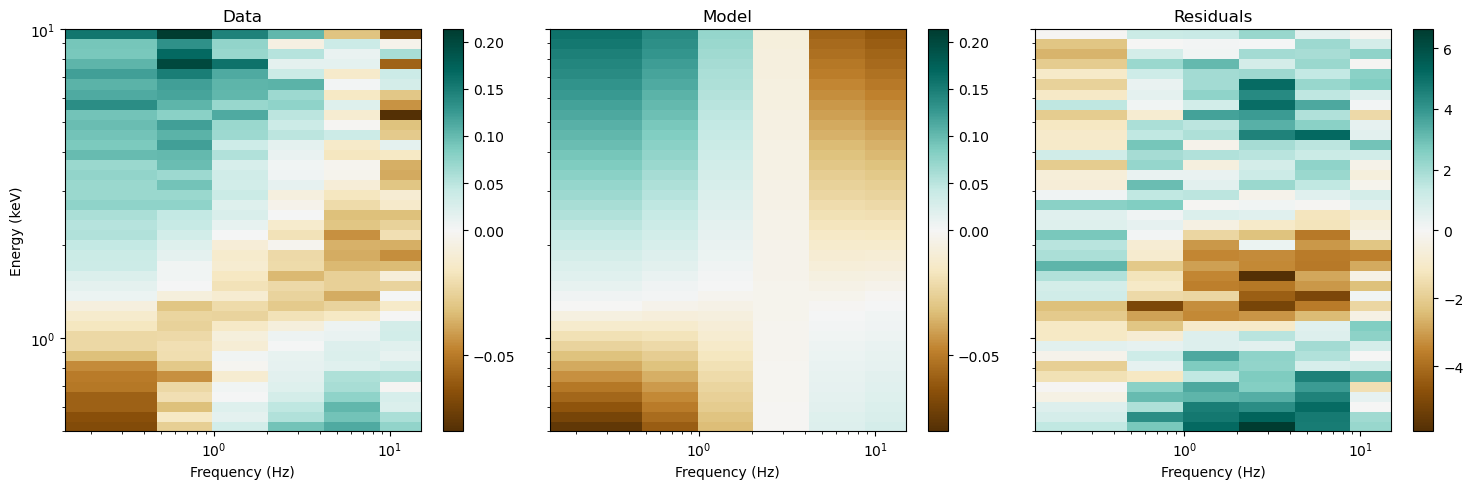

/Users/benr/projects/nDspec/ndspec/Response.py:651: RuntimeWarning: invalid value encountered in divide
  unfold_model = array/unfold_array*channel_widths
/Users/benr/projects/nDspec/ndspec/Response.py:651: RuntimeWarning: divide by zero encountered in divide
  unfold_model = array/unfold_array*channel_widths


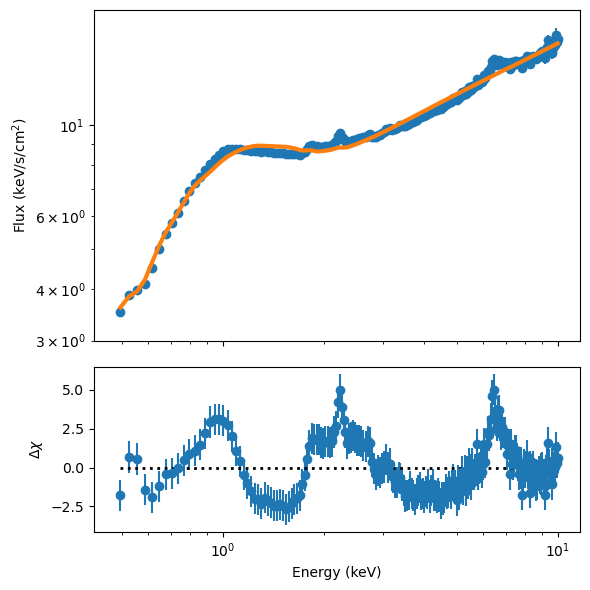

In [15]:
mpl.rcParams.update(mpl.rcParamsDefault)
bigFit.joint["time_lags"].plot_model_1d()
plt.show()
bigFit.joint["time_lags"].plot_model_2d(use_phase=True,return_plot=True)
plt.show()
mpl.rcParams.update(mpl.rcParamsDefault)
bigFit.joint["time_avg_spectrum"].plot_model(units='eeunfold')
plt.show()

# Big phase fit
While we performed a joint fit with the time-averaged spectrum and the time lags, we'd generally prefer to use all of the cross-spectrum information (namely the modulus and calculated phase) as the time lags is just a derivative product of the full cross-spectrum.

Let's respecify both of our models.

In [16]:
from stingray.fourier import get_average_ctrate

def phase_from_lcs(lc_strings,lc_ref,freq_lo,freq_hi,seg_size,timeres):
    time_ref,counts_ref,gtis_ref = load_lc(lc_ref)
    results = avg_pds_from_timeseries(
            time_ref,
            gtis_ref,
            seg_size,
            timeres,
            silent=True,
            norm="none",
            fluxes=counts_ref,
        )
    freq = results["freq"]
    ref_power = results["power"]
    m_ave = results.meta["m"]
    ref_power_noise = poisson_level(norm="none", n_ph=np.sum(counts_ref) / m_ave)
    freq_mask = (freq>freq_lo) & (freq<freq_hi)
    n_freqs = freq_mask[freq_mask==True].size
    mean_ref_power = np.mean(ref_power[freq_mask])
    m_tot = n_freqs * m_ave

    phase_spec = []
    phase_spec_err = []

    for i in range(len(lc_strings)):
        time_sub,counts_sub,gtis_sub = load_lc(lc_strings[i])
        results_cross = avg_cs_from_timeseries(
                time_sub,
                time_ref,
                gtis_sub,
                seg_size,
                timeres,
                silent=True,
                norm="none",
                fluxes1=counts_sub,
                fluxes2=counts_ref,
            )
        results_ps = avg_pds_from_timeseries(
                time_sub,
                gtis_sub,
                seg_size,
                timeres,
                silent=True,
                norm="none",
                fluxes=counts_sub,
            )
        sub_power_noise = poisson_level(
            norm="none", n_ph=np.sum(counts_sub) / results_ps.meta["m"]
        )
        cross = results_cross["power"]
        sub_power = results_ps["power"]
        Cmean = np.mean(cross[freq_mask])
        mean_sub_power = np.mean(sub_power[freq_mask])

        _, _, phi_e, _ = error_on_averaged_cross_spectrum(
                Cmean,
                mean_sub_power,
                mean_ref_power,
                m_tot,
                sub_power_noise,
                ref_power_noise,
                common_ref=True,
            )

        phase = np.angle(Cmean)
        phase_spec = np.append(phase_spec,phase)
        phase_spec_err = np.append(phase_spec_err,phi_e)

    return phase_spec, phase_spec_err

def modulus_from_lcs(lc_strings,lc_ref,freq_lo,freq_hi,seg_size,timeres,norm="abs"):
    time_ref,counts_ref,gtis_ref = load_lc(lc_ref)
    results = avg_pds_from_timeseries(
            time_ref,
            gtis_ref,
            seg_size,
            timeres,
            silent=True,
            norm="abs",
            fluxes=counts_ref*timeres,
        )

    freq = results["freq"]
    ref_power = results["power"]
    m_ave = results.meta["m"]
    countrate_ref = get_average_ctrate(time_ref, gtis_ref, seg_size, counts=counts_ref*timeres)
    ref_power_noise = poisson_level(norm="abs", meanrate=countrate_ref)
    freq_mask = (freq>freq_lo) & (freq<freq_hi)
    n_freqs = freq_mask[freq_mask==True].size
    mean_ref_power = np.mean(ref_power[freq_mask])
    m_tot = n_freqs * m_ave
    delta_nu = n_freqs / seg_size

    f_mean = (freq_lo + freq_hi)*0.5

    mod_spec = []
    mod_spec_err = []

    for i in range(len(lc_strings)):
        time_sub,counts_sub,gtis_sub = load_lc(lc_strings[i])
        results_cross = avg_cs_from_timeseries(
                time_sub,
                time_ref,
                gtis_sub,
                seg_size,
                timeres,
                silent=True,
                norm="abs",
                fluxes1=counts_sub*timeres,
                fluxes2=counts_ref*timeres,
            )

        results_ps = avg_pds_from_timeseries(
                time_sub,
                gtis_sub,
                seg_size,
                timeres,
                silent=True,
                norm="abs",
                fluxes=counts_sub*timeres,
            )
        countrate_sub = get_average_ctrate(time_sub, gtis_sub, seg_size, counts=counts_sub*timeres)
        sub_power_noise = poisson_level(norm="abs", meanrate=countrate_sub)
        cross = results_cross["power"]
        sub_power = results_ps["power"]
        Cmean = np.mean(cross[freq_mask])
        mean_sub_power = np.mean(sub_power[freq_mask])

        _, _, _, mod_e = error_on_averaged_cross_spectrum(
                Cmean,
                mean_sub_power,
                mean_ref_power,
                m_tot,
                sub_power_noise,
                ref_power_noise,
                common_ref=True,
            )
        modulus = np.abs(Cmean)

        if norm == "frac":
            modulus, mod_e = modulus / countrate_sub, mod_e / countrate_sub

        mod_spec = np.append(mod_spec,modulus)
        mod_spec_err = np.append(mod_spec_err,mod_e)

    return mod_spec, mod_spec_err

phases = []
phases_err = []
mods = []
mods_err = []

norm_data="abs"

for i in show_progress(range(6)):
    phi,phi_err=phase_from_lcs(fine_full_string,ref_path,freqs[i],freqs[i+1],segment_size,dt)
    phases = np.append(phases,phi)
    phases_err=np.append(phases_err,phi_err)

    mod,mod_err=modulus_from_lcs(fine_full_string,ref_path,freqs[i],freqs[i+1],segment_size,dt)
    mods=np.append(mods,mod)
    mods_err=np.append(mods_err,mod_err)


100%|██████████| 6/6 [00:29<00:00,  4.88s/it]


In [17]:
bigCrossFit = JointFit()

time_avg_fit = fitspec.FitTimeAvgSpectrum()
time_avg_fit.set_data(rebin_matrix,os.getcwd()+'/spectra/1200120106_rebin.pha')
unfolded_model = LM_Model(wrap_tbabs)*(LM_Model(powerlaw)+LM_Model(wrap_diskbb))

start_params = unfolded_model.make_params(index=dict(value=-1.65,min=-3.0,max=-1.0),
                                          norm_pl=dict(value=6.5,min=1e-1,max=50.),
                                          kT=dict(value=0.25,min=0.10,max=1),
                                          norm_disk=dict(value=2e5,min=1e1,max=1e8),
                                          nH=dict(value=0.1,min=1e-3,max=10))

time_avg_fit.set_model(unfolded_model,params=start_params)
time_avg_fit.ignore_energies(0,0.5)
time_avg_fit.ignore_energies(10.0,20.0)

cross_fit = fitcross.FitCrossSpectrum()
cross_fit.set_coordinates("polar")
cross_fit.set_product_dependence("energy")

full_data = np.append(mods,phases)
mods_err_sys = np.sqrt(mods_err**2+0.005*mods**2)
full_errs = np.append(mods_err_sys,phases_err)

#pass the data, errors, response, and time/frequency grid information identically to lags alone
cross_fit.set_data(nicer_matrix,ref_band,fine_channel_grid_edges,
                  full_data,full_errs,
                  freq_bins=freqs,
                  time_res=dt,seg_size=segment_size)

cross_fit.ignore_energies(0,0.5)
cross_fit.ignore_energies(10.0,fine_channel_grid_edges[-1])


In [18]:
cross_fit.set_model(timing_model,model_type="transfer")
cross_fit.set_psd_weights(psd)
cross_fit.set_params(no_renorm_params)
cross_fit.model_params['norm_pl2'].vary=True
cross_fit.model_params['norm_pl2'].value=5*no_renorm_params['norm_pl2'].value
cross_fit.model_params['rev_norm'].value=5*no_renorm_params['rev_norm'].value

 - Adding parameter "nH"
 - Adding parameter "norm_pl2"
 - Adding parameter "index"
 - Adding parameter "gamma_0"
 - Adding parameter "gamma_slope"
 - Adding parameter "phi_0"
 - Adding parameter "phi_slope"
 - Adding parameter "nu_0"
 - Adding parameter "cutoff"
 - Adding parameter "rev_norm"
 - Adding parameter "rev_temp"
 - Adding parameter "rise_slope"
 - Adding parameter "decay_slope"
 - Adding parameter "peak_time"
 - Adding parameter "temp_slope"


In [19]:
cross_fit.renorm_phases(True)
cross_fit.renorm_mods(True)

In [20]:
from timeit import Timer
print("Cross fit evaluations before added to joint fit:")
%timeit test = cross_fit.eval_model()
print("Time averaged Fit before added to joint fit:")
%timeit test = time_avg_fit.eval_model()

Cross fit evaluations before added to joint fit:
54 ms ± 1.31 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Time averaged Fit before added to joint fit:
10.9 ms ± 6.85 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
bigCrossFit.add_fitobj(time_avg_fit,"time_avg_spectrum")
bigCrossFit.add_fitobj(cross_fit,"cross_spectrum")


                              Caution: nH is already a model parameter.
                              Do you intend for these parameters to be linked?
                              If not, give it a different name to differentiate
                              between multiple instances of the same type for
                              different models.
                              

                              Caution: index is already a model parameter.
                              Do you intend for these parameters to be linked?
                              If not, give it a different name to differentiate
                              between multiple instances of the same type for
                              different models.
                              


In [23]:
bigCrossFit.fit_data()

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1319
    # data points      = 715
    # variables        = 25
    chi-square         = 2658.70506
    reduced chi-square = 3.85319574
    Akaike info crit   = 989.018024
    Bayesian info crit = 1103.32509
[[Variables]]
    nH:              0.09999619 +/- 0.00440483 (4.41%) (init = 0.1)
    index:          -1.60987985 +/- 0.00768200 (0.48%) (init = -1.65)
    norm_pl:         6.38269164 +/- 0.08086270 (1.27%) (init = 6.5)
    kT:              0.23181251 +/- 0.00434560 (1.87%) (init = 0.25)
    norm_disk:       359820.056 +/- 45497.0108 (12.64%) (init = 200000)
    norm_pl2:        3.78173643 +/- 590.640382 (15618.23%) (init = 5)
    gamma_0:         0.15721582 +/- 0.02028974 (12.91%) (init = 0.046)
    gamma_slope:    -0.03099148 +/- 0.01154340 (37.25%) (init = -0.016)
    phi_0:          -0.41660594 +/- 0.08289452 (19.90%) (init = -2.31)
    phi_slope:       0.43057561 +/- 0.08411718 (19.54%) (init = 2.01)
  

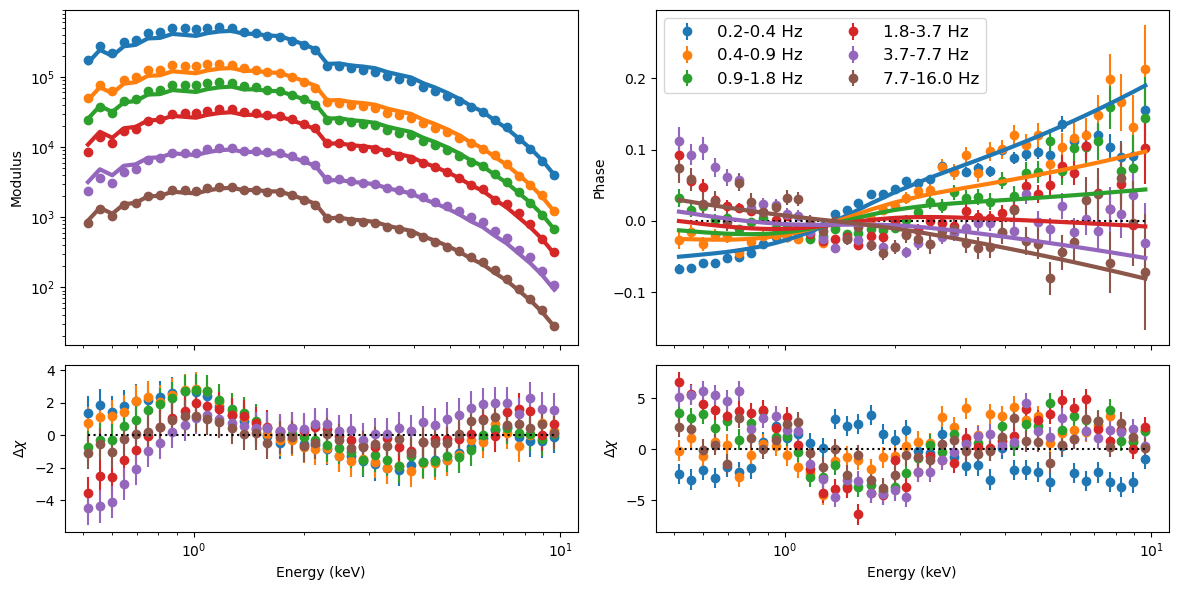

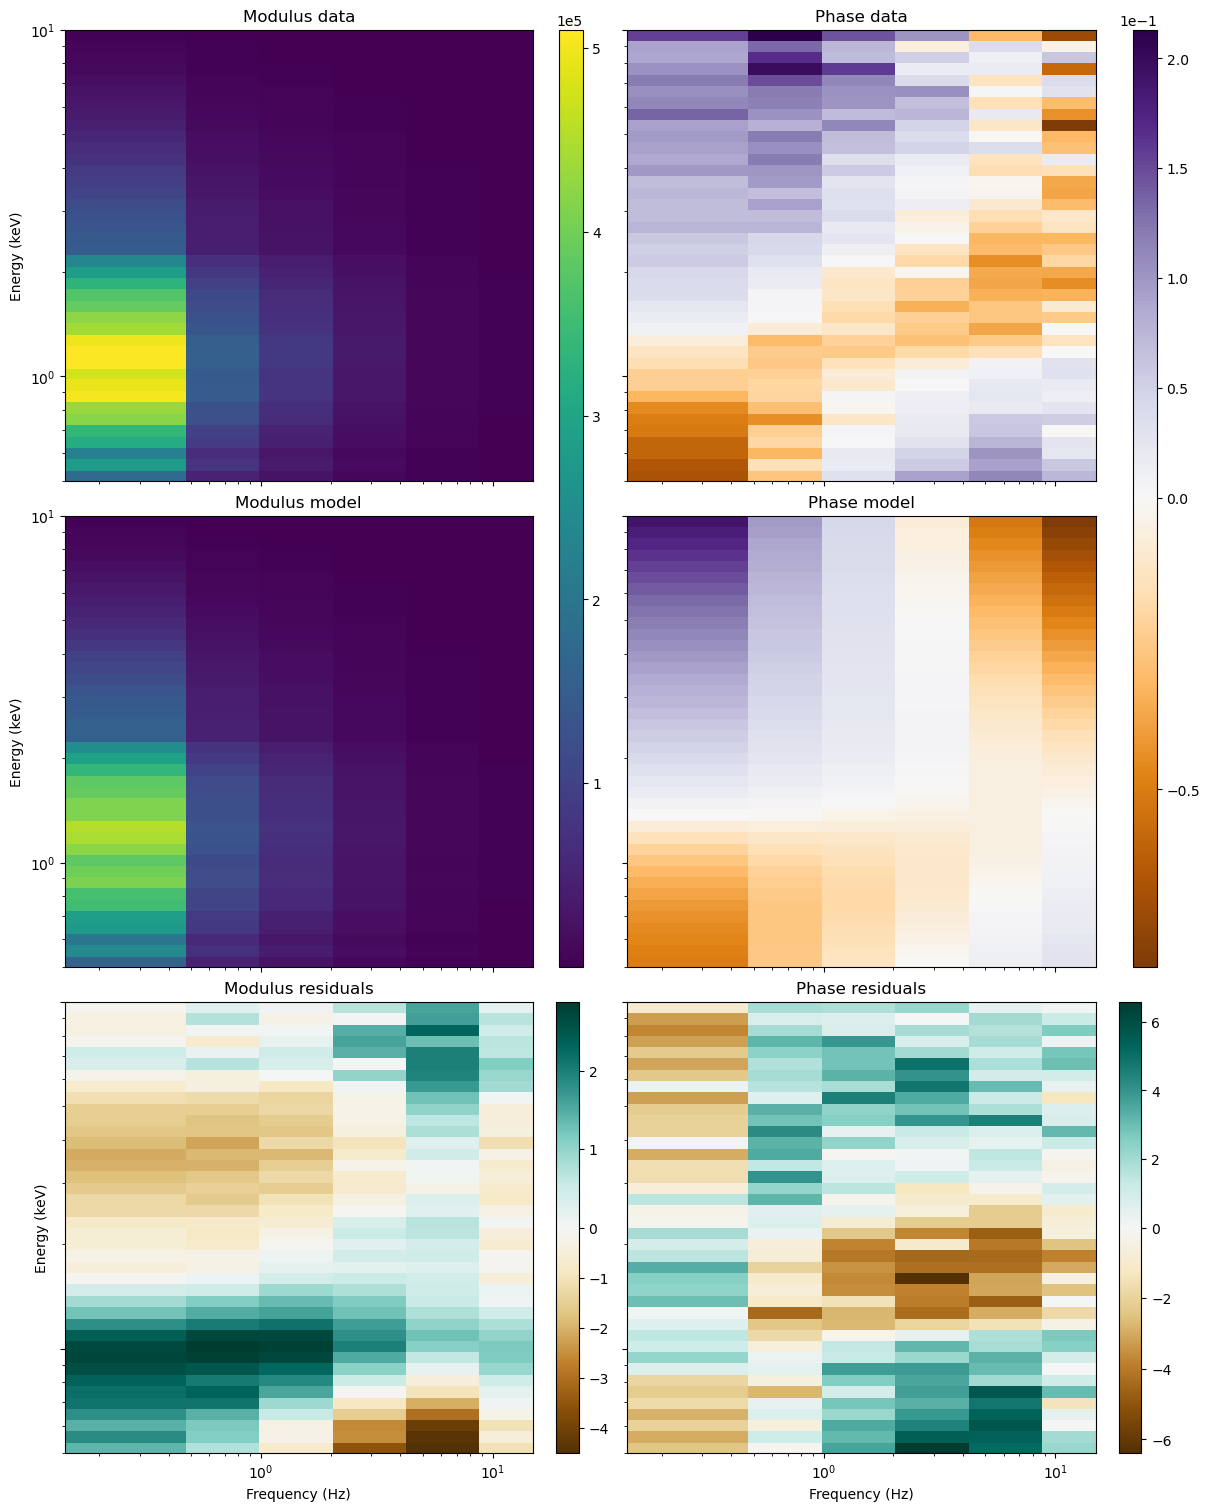

/Users/benr/projects/nDspec/ndspec/Response.py:651: RuntimeWarning: invalid value encountered in divide
  unfold_model = array/unfold_array*channel_widths
/Users/benr/projects/nDspec/ndspec/Response.py:651: RuntimeWarning: divide by zero encountered in divide
  unfold_model = array/unfold_array*channel_widths


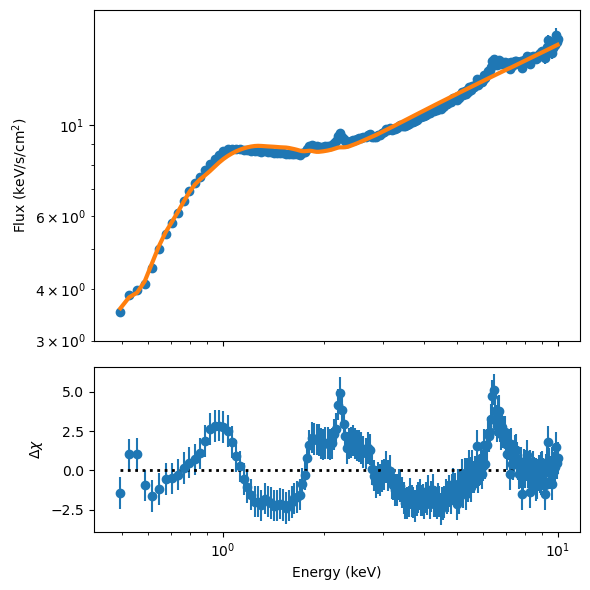

In [24]:
bigCrossFit.joint["cross_spectrum"].plot_model_1d()
plt.show()
bigCrossFit.joint["cross_spectrum"].plot_model_2d()
plt.show()
bigCrossFit.joint["time_avg_spectrum"].plot_model(units='eeunfold')
plt.show()

# MCMC

Now let's try MCMC. We'll use ndspec's MCMC utilities to do this. There is functionally no difference between using MCMC for a single power spectrum or time-averaged spectrum fit and the joint fitting that we'll perform here except that we'll obviously have a lot more parameters and thus will take quite a bit longer to converge.

In [25]:
import ndspec.EmceeUtils as ndmc

#first we'll specify our priors
nH_prior = ndmc.priorUniform(0.02,2)
index_prior = ndmc.priorUniform(-2.2,-1.2)
norm_pl_prior = ndmc.priorLogUniform(1e-1,50)
kT_prior = ndmc.priorUniform(1e-1,1.)

norm_disk_prior = ndmc.priorLogUniform(1e0,1e8)
norm_pl2_prior = ndmc.priorLogUniform(1e-3,1e4)
gamma_0_prior = ndmc.priorUniform(0,0.5)
gamma_slope_prior = ndmc.priorUniform(-0.2,0.0)
phi_0_prior = ndmc.priorUniform(-3,3)
phi_slope_prior = ndmc.priorUniform(-3,3)

rev_norm_prior = ndmc.priorLogUniform(1e-3,1e4)
rev_temp_prior = ndmc.priorUniform(0.05,1)
rise_slope_prior = ndmc.priorUniform(-10,10)
peak_time_prior = ndmc.priorLogUniform(1e-5,1)
decay_slope_prior = ndmc.priorUniform(-10,10)
temp_slope_prior = ndmc.priorUniform(-3,3)
phase_renorm_prior = ndmc.priorNormal(0.05,0)
mod_renorm_prior = ndmc.priorNormal(0.15,1)
#mod_renorm_prior = ndmc.priorUniform(0.5,2)

my_priors = {
    "nH": nH_prior,
    "index": index_prior,
    "norm_pl": norm_pl_prior,
    "kT": kT_prior,
    "norm_disk": norm_disk_prior,
    "norm_pl2": norm_pl2_prior,
    "gamma_0": gamma_0_prior,
    "gamma_slope": gamma_slope_prior,
    "phi_0": phi_0_prior,
    "phi_slope": phi_slope_prior,
    "rev_norm": rev_norm_prior,
    #"rev_temp": rev_temp_prior,
    #"rise_slope": rise_slope_prior,
    "decay_slope": decay_slope_prior,
    #"peak_time": peak_time_prior,
    "temp_slope": temp_slope_prior,
    "phase_renorm_1": phase_renorm_prior,
    "phase_renorm_2": phase_renorm_prior,
    "phase_renorm_3": phase_renorm_prior,
    "phase_renorm_4": phase_renorm_prior,
    "phase_renorm_5": phase_renorm_prior,
    "phase_renorm_6": phase_renorm_prior,
    "mods_renorm_1": mod_renorm_prior,
    "mods_renorm_2": mod_renorm_prior,
    "mods_renorm_3": mod_renorm_prior,
    "mods_renorm_4": mod_renorm_prior,
    "mods_renorm_5": mod_renorm_prior,
    "mods_renorm_6": mod_renorm_prior,
}

#intialise mcmc (returns starting parameters)
theta = ndmc.initialise_mcmc(bigCrossFit,my_priors)

ndim = len(theta)
nwalkers = 48 if 48 > 2*ndim else 2*ndim
steps = 25000
#this needs to change to only shift the parameters that are varying
pos = theta*(1+ 1e-2 * np.random.randn(nwalkers, len(theta)))

In [26]:
#first, quick run to make sure it makes sense
import emcee
import time
import corner
from multiprocessing import Pool
import cProfile

lags_path = os.getcwd()+"/mcmc_chains/joint_fit.h5"
backend = emcee.backends.HDFBackend(lags_path)
backend.reset(nwalkers, ndim)

with Pool() as pool:
    parallel_sampler = emcee.EnsembleSampler(nwalkers, ndim, ndmc.chi_square_likelihood, 
                                             pool=pool, backend=backend,
                                             #moves=[(emcee.moves.DEMove(), 0.8),
                                             #       (emcee.moves.DESnookerMove(), 0.2),]
                                            )                                     
    start = time.time()
    parallel_sampler.run_mcmc(pos, steps, progress=True);
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))

  0%|          | 116/25000 [01:14<4:34:32,  1.51it/s]Process ForkPoolWorker-10:
Process ForkPoolWorker-9:
Process ForkPoolWorker-8:
Process ForkPoolWorker-7:


emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:  params:

   params:  params:emcee: Exception while calling your likelihood function:[ 1.01939810e-01 -1.60661194e+00  6.35900491e+00  2.33340832e-01
  3.56057294e+05  3.78702004e+00  1.55647010e-01 -3.41849764e-02
 -4.30627775e-01  4.31715850e-01  1.08916763e+00 -1.18286408e+00
 -1.88374725e-10 -1.61152129e-02 -1.01476239e-02 -6.81819169e-03
 -3.76180419e-03  5.36559306e-04  9.55903377e-03  1.25364702e+00
  2.18733772e+00  1.35984187e+00  9.95917031e-01  1.13010500e+00
  1.47891538e+00]  

[ 1.00727300e-01 -1.61362734e+00  6.43039948e+00  2.32995308e-01
  3.45883368e+05  3.75822724e+00  1.57994612e-01 -3.08742260e-02
 -4.16304431e-01  4.09985934e-01  1.10618271e+00 -1.12541530e+00
 -1.71113617e-10 -1.79319469e-02 -9.73700394e-03 -7.17981657e-03
 -4.04802828e-03  5.32672338e-04  9.34098588e-03  1.31847017e+00
  1.97703

Process ForkPoolWorker-2:


[ 1.03924211e-01 -1.60607541e+00  6.37389038e+00  2.33912062e-01
  3.43060609e+05  3.81437740e+00  1.60043815e-01 -3.07957324e-02
 -4.01232852e-01  4.20503729e-01  1.09431469e+00 -1.13798647e+00
 -1.81882513e-10 -1.71264163e-02 -1.02181846e-02 -6.98215335e-03
 -3.47840011e-03  5.13412690e-04  9.11063623e-03  1.23654276e+00
  1.98162118e+00  1.35948411e+00  9.65897296e-01  1.11114149e+00
  1.42089743e+00]  params:  args:
emcee: Exception while calling your likelihood function:
    args:

  0%|          | 116/25000 [01:14<4:26:02,  1.56it/s]


  args:[] [ 1.03809111e-01 -1.60556159e+00  6.34955919e+00  2.33703659e-01
  3.62560470e+05  3.81533500e+00  1.59254605e-01 -3.16782090e-02
 -4.18371186e-01  4.18293078e-01  1.10541238e+00 -1.13716896e+00
 -1.73562244e-10 -1.69628818e-02 -9.37495116e-03 -6.88431031e-03
 -3.92027987e-03  5.33476636e-04  9.25613573e-03  1.27685129e+00
  1.92618288e+00  1.29588289e+00  1.00366352e+00  1.06144762e+00
  1.43031337e+00]  params: 
[]
 []  kwargs:
  args:
   kwargs:{}  kwargs: 
 {}  exception:{}

  exception:

KeyboardInterrupt: 

In [ ]:
fit_names = []
fit_values = []
for key in bigCrossFit.model_params:
    if bigCrossFit.model_params[key].vary is True:
        fit_names = np.append(fit_names,bigCrossFit.model_params[key].name)
        fit_values = np.append(fit_values,bigCrossFit.model_params[key].value)

test_names = ["$A_0$","$\\gamma_0$","$\\gamma_s$","$\\phi_0$","$\\phi_s$","$R_0$","$kT_0$","$s_2$","$s_t$",
              "p1","p2","p3","p4","p5","p6",
              "m1","m2","m3","m4","m5","m6",
             ]

#crappy discarding/thinning, this is just a sanity check
ndmc.process_emcee(parallel_sampler,labels=fit_names,values=fit_values,discard=600,thin=200)

In [ ]:
flat_samples = parallel_sampler.get_chain(discard=600, thin=200, flat=True)
mpl.rcParams.update(mpl.rcParamsDefault)
fig = corner.corner(
    flat_samples[:,:], labels=fit_names[:], truths=fit_values[:]
)

plt.show()

In [ ]:
flat_samples = parallel_sampler.get_chain(discard=600, thin=200, flat=True)

fig = corner.corner(
    flat_samples[:,-6:-1], 
    labels = fit_names[-6:-1], 
    truths = fit_values[-6:-1]
)
plt.show()

In [ ]:
#and finally, we print out the credible intervals

for i in range(ndim):
    #calculate the mean of the posterior
    mean = np.mean(flat_samples[:, i])

    #get the median and one sigma percentiles
    onesigma_percentile = np.percentile(flat_samples[:, i], [16, 50, 84])
    onesigma_interval = np.diff(onesigma_percentile)

    #also get the two sigma percentiles
    twosigma_percentile = np.percentile(flat_samples[:, i], [5, 50, 95])
    twosigma_interval = np.diff(twosigma_percentile)

    #make the printing more readable
    print_space = len(fit_names[i])+2
    print(f"{fit_names[i]}; mean: {mean:.3f}; median: {onesigma_percentile[1]:.3f}; optimizer: {fit_values[i]:.3f}")
    print(" "*print_space + f"1-\u03C3 range from median: +{onesigma_interval[1]:.3f} -{onesigma_interval[0]:.3f}")
    print(" "*print_space + f"2-\u03C3 range: +{twosigma_interval[1]:.3f} -{twosigma_interval[0]:.3f}")

In [ ]:
from timeit import Timer
print("Joint Fit:")
%timeit test = bigCrossFit.eval_model()
print("Joint Cross Fit:")
%timeit test = bigCrossFit.joint["cross_spectrum"].eval_model()
print("Pure Cross Fit:")
%timeit test = cross_fit.eval_model()
print("Time averaged Fit:")
%timeit test = bigCrossFit.joint["time_avg_spectrum"].eval_model()
print("Likelihood evaluation:")
%timeit test = ndmc.chi_square_likelihood(theta)